In [10]:
### Import packages

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

from learnspec.functions import directories, stacking, readspec

from astropy.stats import sigma_clipped_stats
import astropy.units as u

import pandas as pd

### For ML
import tensorflow as tf
from tensorflow.keras import layers, Model


plt.style.use('/Users/aayushsaxena/Desktop/Oxford/plt_styles/as_jades.mplstyle')


In [5]:
### List of all input redshift catalogues
all_redshifts = ["/Users/aayushsaxena/Desktop/Oxford/JADES/GS-HST-DEEP/visual_inspection_hst_gs_deep_v0.7.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-1287/visual_redshifts_consolidated_1287_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-3215/visual_redshifts_consolidated_ultra_deep_gs_3215_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-HST-MEDIUM/visual_redshifts_hst_medium_redo_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-JWST-MEDIUM-1180/visual_redshifts_JWST_Medium_1180_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-JWST-MEDIUM-1286/visual_redshifts_1286_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GN-HST-MEDIUM/visual_redshifts_consolidated_gn_hst_medium_1181_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GN-JWST-MEDIUM/visual_redshifts_consolidated_gn_jwst_medium_1181_v0.6.csv"]

all_surveys = ['GS-HST-DEEP', 'GS-JWST-DEEP', 'GS-3215', 'GS-HST-MEDIUM', 'GS-JWST-MEDIUM-1180', 'GS-JWST-MEDIUM-1286', 'GN-HST-MEDIUM', 'GN-JWST-MEDIUM']

# Pre-processing of the data

In [ ]:
### It is possible to load in multiple redshift catalogues and combine them
### This is useful if you want to stack sources from multiple surveys
speclist = []
redshifts = []
for i in range(len(all_redshifts)):
    input_cat = pd.read_csv(all_redshifts[i])
    survey = all_surveys[i]
    grating = "prism"
    redshift_range = (4,16)
    specdir, version = directories.translate_dir(survey, grating)
    speclist_temp, redshifts_temp = directories.select_sources(input_cat, specdir, redshift_range, grating, version)
    speclist.extend(speclist_temp)
    redshifts.extend(redshifts_temp)


total_sources = len(speclist)
print(f"Number of sources with z > {redshift_range[0]} and z < {redshift_range[1]}: {total_sources}")

Number of sources with z > 6 and z < 16: 221


In [9]:
# First step is to de-redshift, renormalize and resample all the spectra on to a common wavelength grid
# The renormalization for the majority of the spectra is done such that the flux at 1500A rest frame is set to 1
# For grating spectra, currently no renormalization is done
# Pick the desired resolution of the final stack
resolution = 3.0

if grating == 'prism':
    mean_stack, median_stack, std_stack, resampled_spec = stacking.sigma_clipped_stacking(speclist, redshifts, resolution=resolution, sigma=200.0)
else:
    mean_stack, median_stack, std_stack, resampled_spec = stacking.stack_grating(speclist, redshifts, grating=grating, resolution=resolution)

### Convert resampled_spec array to numpy array for future operations
resampled_spec_np = np.array(resampled_spec)


/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/specutils/manipulation/resample.py:217: RuntimeWarning: divide by zero encountered in reciprocal
  output_errs = InverseVariance(np.reciprocal(output_errs))
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/specutils/manipulation/resample.py:217: RuntimeWarning: divide by zero encountered in reciprocal
  output_errs = InverseVariance(np.reciprocal(output_errs))
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/specutils/manipulation/resample.py:217: RuntimeWarning: divide by zero encountered in reciprocal
  output_errs = InverseVariance(np.reciprocal(output_errs))
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/specutils/manipulation/resample.py:217: RuntimeWarning: divide by zero encountered in reciprocal
  output_errs = InverseVariance(np.reciprocal(output_errs))
/Users/aayushsaxena/Desktop/

## Dimensionality reduction and clustering analysis on resampled spectra

### Pre-processing the data

In [11]:
### Let's remove NaN values from the spectra by setting them to 0
for i in range(len(resampled_spec)):
    resampled_spec[i].data[np.isnan(resampled_spec[i].data)] = 0.0
    resampled_spec[i].data[np.isinf(resampled_spec[i].data)] = 0.0

### First only extract the data from the resampled spectra
resampled_data = np.array([spec.data for spec in resampled_spec])

### Furthermore, let's minmax normalize the data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# resampled_data = scaler.fit_transform(resampled_data)

### Also try and standardize the data instead
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# resampled_data = scaler.fit_transform(resampled_data)

### To preserve the emission line features, we can also use the RobustScaler
# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# resampled_data = scaler.fit_transform(resampled_data)

### Implement arcsinh transformation, which is good for spectra that have strong emission lines
# from sklearn.preprocessing import FunctionTransformer
# arcsinh_transformer = FunctionTransformer(np.arcsinh, validate=True)
# resampled_data = arcsinh_transformer.fit_transform(resampled_data)

### Save the transformed data for later use
# np.save("../data/resampled_data_z4_16.npy", resampled_data)
### Save the corresponding wavelength axis
# np.save("../data/wavelength_z4_16.npy", resampled_spec[0].spectral_axis.value)

### Load the transformed data
resampled_data = np.load("../data/resampled_data_z4_16.npy")
wavelength = np.load("../data/wavelength_z4_16.npy")

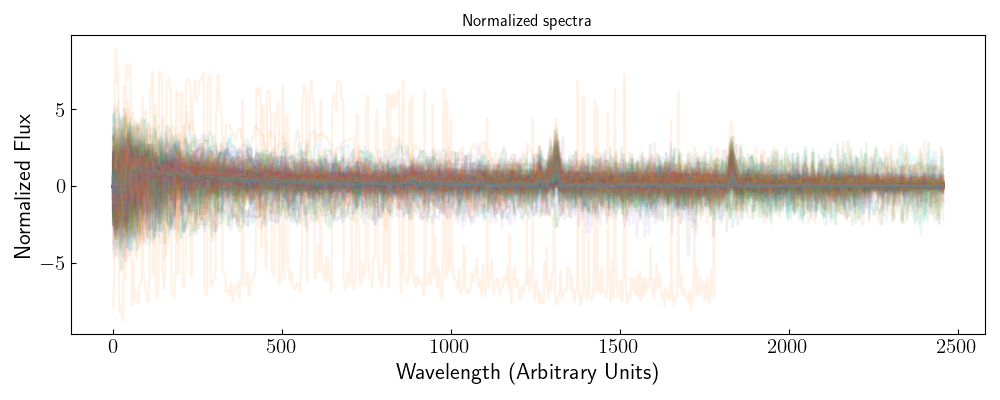

In [12]:
### Plot the normalized data
plt.close()
plt.figure(figsize=(10,4))
plt.plot(resampled_data.T, alpha=0.1)
plt.xlabel("Wavelength (Arbitrary Units)")
plt.ylabel("Normalized Flux")
plt.title("Normalized spectra")
plt.tight_layout()
plt.show()

In [ ]:
### Print the summary statistics of the data
print(np.min(resampled_data), np.max(resampled_data), np.mean(resampled_data), np.std(resampled_data))

-8.73882450540276 8.959384302773309 0.22975419098401628 0.47994667704093263


Exception ignored in: <function ResourceTracker.__del__ at 0x105bcd620>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1020f9620>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/

In [14]:
### Prepare the data for the VAE
# Set input dimensions
input_dim = len(resampled_data[0])  # Change this to your spectral length
print(f"Input dimension: {input_dim}")
latent_dim = 16  # Change this to your desired latent dimension

Input dimension: 2459


In [15]:
# === Encoder ===
inputs = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

# === Decoder ===
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(input_dim, activation='linear')(x)  # use linear activation for reconstruction

decoder = Model(latent_inputs, outputs, name="decoder")

# === Custom VAE Model ===
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # === Masking regions where data == 0 (i.e., formerly NaN) ===
            mask = tf.cast(tf.not_equal(data, 0.0), tf.float32)
            diff = mask * (data - reconstruction)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(diff), axis=1))

            # KL divergence (safe)
            z_log_var_clipped = tf.clip_by_value(z_log_var, -10.0, 10.0)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var_clipped - tf.square(z_mean) - tf.exp(z_log_var_clipped), axis=1
            ))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

# === Compile and Train ===
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


In [ ]:
### Training the model
vae.fit(resampled_data, epochs=500, batch_size=64, shuffle=True)

In [ ]:
### Extract the latent space representation
z_mean, _, _ = encoder.predict(resampled_data)